# Introduction

The procedure to build a VAR model involves the following steps:

1. Analyze the time series characteristics
<br>
2. Test for causation amongst the time series
<br>
3. Test for stationarity
<br>
4. Transform the series to make it stationary, if needed
<br>
5. Find optimal order (p)
<br>
6. Prepare training and test datasets
<br>
7. Train the model
<br>
8. Roll back the transformations
<br>
9. Evaluate the model using test set
<br>
10. Forecast to future

# Import packages

Import packages such as pandas, numpy, matplotlib, scipy and statsmodels

In [52]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr

# Data importing, cleaning and preprocessing

Monthly data for the period January 2008 to January 2022 were sourced from Bloomberg and saved in an excel spreadsheet, with one dependent and eleven independent variables. (169)
<br>

The following data were collected:
<br>

- iShares J.P. Morgan USD Emerging Markets Bond ETF
- DAX Index
- VIX Index
- US 10-year government bond yield
- Euro / U.S. Dollar 
- Bloomberg US Corporate High-Yield Average OAS
- 2-year 10-year yield spread
- Euro Stoxx 50
- S&P 500 Indes
- Gold
- US 10-year breakeven rate
- U.S. Dollar Index

Logarithmic returns were calculated for the iShares J.P. Morgan USD Emerging Markets Bond ETF time-series and some data cleaning and preprocessing has been done.

In [53]:
df = pd.read_excel("Data.xlsx", sheet_name="Monthly_Python_Input", index_col=0)
#df = df.drop(columns=["EMB_US_Equity"])
df["EMB_US_Equity_log"] = np.log(df.EMB_US_Equity) - np.log(df.EMB_US_Equity.shift(1))
df = df.drop(columns=["EMB_US_Equity"]).dropna()
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
print(df.head())
print(df.tail())
print(df.shape) # (168, 12)

            EMB_US_Equity_log  Dax_Index  VIX_Index  USGG10YR_Index  \
Date                                                                  
2008-02-29          -0.008737    6748.13      26.54          3.5092   
2008-03-31          -0.003259    6534.97      25.61          3.4096   
2008-04-30           0.006999    6948.82      20.79          3.7279   
2008-05-30          -0.003345    7096.79      17.83          4.0595   
2008-06-30          -0.024545    6418.32      23.95          3.9690   

            EURUSD_BGN_Curncy  LF98OAS_Index  USYC2Y10_Index  SX5E_Index  \
Date                                                                       
2008-02-29             1.5179           7.45         189.578     3724.50   
2008-03-31             1.5788           7.81         182.115     3628.06   
2008-04-30             1.5622           6.53         146.961     3825.02   
2008-05-30             1.5554           6.22         145.713     3777.85   
2008-06-30             1.5755           7.08  

# 1. Analyze the time series characteristics

Descriptive statistics

In [54]:
display(df.describe())

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,0.000176,9646.913214,20.374226,2.328403,1.247545,5.455060,140.953696,3117.319405,2115.345476,1355.810357,1.952763,87.900018
std,0.034245,3068.766621,8.990890,0.796853,0.130282,2.611803,78.091019,490.938235,946.142135,280.165019,0.408435,8.564552
min,-0.220326,3843.740000,9.510000,0.528200,1.051700,2.680000,-1.391000,1976.230000,735.090000,723.850000,0.088900,71.802000
25%,-0.010442,6835.125000,14.022500,1.765875,1.127925,3.710000,78.947250,2763.087500,1325.047500,1184.370000,1.735400,80.083750
50%,0.002441,9819.310000,17.745000,2.318650,1.223250,4.770000,140.939500,3130.970000,1999.180000,1300.655000,2.001050,89.883000
75%,0.014490,12203.462500,24.160000,2.860175,1.345600,6.270000,203.000500,3468.560000,2712.262500,1581.130000,2.243000,95.840750
max,0.152693,15884.860000,59.890000,4.059500,1.578800,18.330000,280.778000,4298.410000,4766.180000,1975.860000,2.594700,102.210000


Correlation matrix

In [55]:
display(df.corr())

,EMB_US_Equity_log,Dax_Index,VIX_Index,USGG10YR_Index,EURUSD_BGN_Curncy,LF98OAS_Index,USYC2Y10_Index,SX5E_Index,SPX_Index,XAU BGN Curncy,USGGBE10 Index,DXY Curncy
EMB_US_Equity_log,1.000000,-0.023729,-0.253198,-0.102464,0.068512,-0.001733,-0.015768,-0.026599,-0.030058,0.055477,-0.050786,-0.067519
Dax_Index,-0.023729,1.000000,-0.425564,-0.546360,-0.705115,-0.702438,-0.705767,0.846289,0.949572,0.436941,0.079627,0.752968
VIX_Index,-0.253198,-0.425564,1.000000,0.048849,0.194393,0.779575,0.174452,-0.410337,-0.242238,-0.115388,-0.499724,-0.168314
USGG10YR_Index,-0.102464,-0.546360,0.048849,1.000000,0.615461,0.284694,0.551021,-0.175679,-0.594029,-0.747648,0.209428,-0.529718
EURUSD_BGN_Curncy,0.068512,-0.705115,0.194393,0.615461,1.000000,0.332001,0.715192,-0.387366,-0.619927,-0.237538,0.377126,-0.968212
LF98OAS_Index,-0.001733,-0.702438,0.779575,0.284694,0.332001,1.000000,0.341067,-0.611752,-0.600283,-0.470263,-0.586813,-0.307322
USYC2Y10_Index,-0.015768,-0.705767,0.174452,0.551021,0.715192,0.341067,1.000000,-0.482651,-0.687366,-0.291023,0.261540,-0.765381
SX5E_Index,-0.026599,0.846289,-0.410337,-0.175679,-0.387366,-0.611752,-0.482651,1.000000,0.794582,0.130235,0.214144,0.504423
SPX_Index,-0.030058,0.949572,-0.242238,-0.594029,-0.619927,-0.600283,-0.687366,0.794582,1.000000,0.553078,0.091118,0.670736
XAU BGN Curncy,0.055477,0.436941,-0.115388,-0.747648,-0.237538,-0.470263,-0.291023,0.130235,0.553078,1.000000,0.316722,0.122545


Visualization

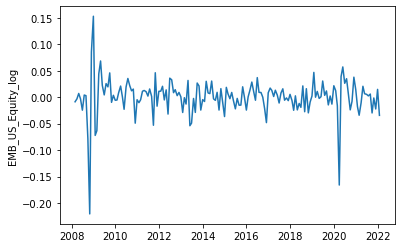

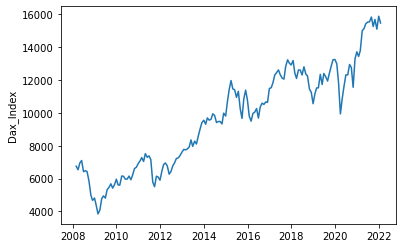

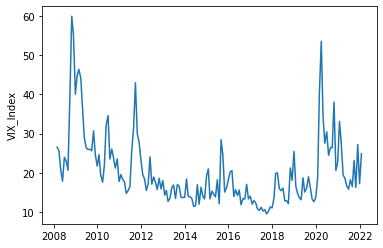

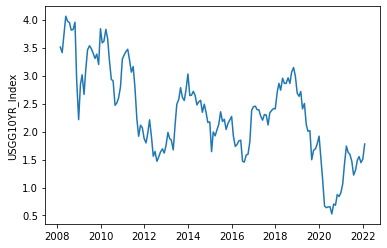

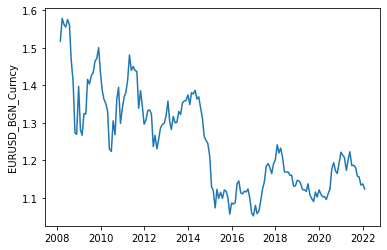

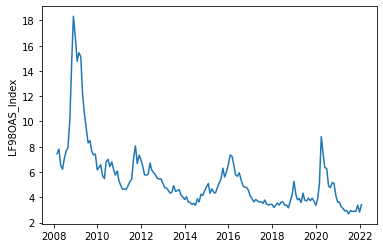

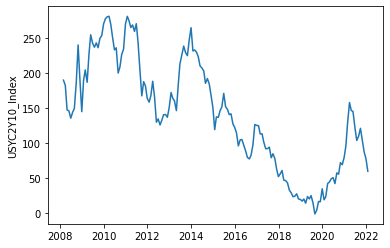

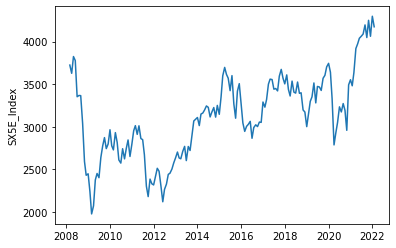

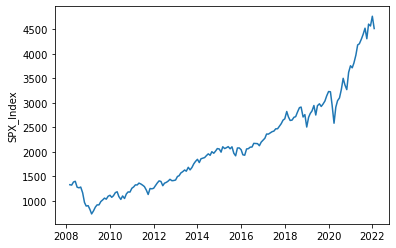

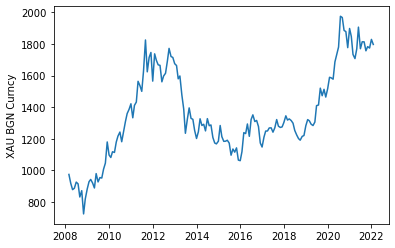

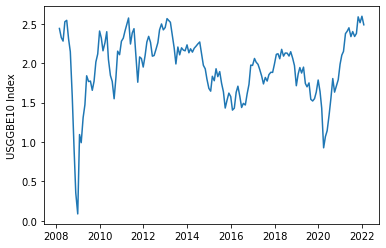

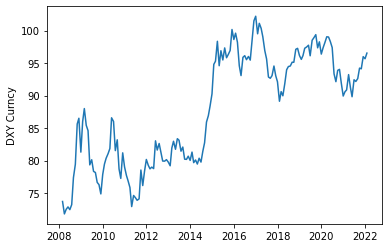

In [56]:
ind = df.columns
for x in ind:
    plt.plot(df[[x]])
    plt.ylabel(x)
    plt.show()

# 3. Test for stationarity

In [57]:
# split data into training and testing
nobs = 4
df_train, df_test = df[:-nobs], df[-nobs:]

# check size
print(df_train.shape) # (164, 12)
print(df_test.shape) # (4, 12)


def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

(164, 12)
(4, 12)
    Augmented Dickey-Fuller Test on "EMB_US_Equity_log" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.1746
 No. Lags Chosen       = 0
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Dax_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.3742
 No. Lags Chosen       = 0
 Critical value 1%     = -3.471
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.9143. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "VIX_Index" 
    -----------------------------------------------
 Null Hypothesis: